In [2]:
import torch
from torch import nn # contains all the neural network building blocks
from torch.optim import SGD # contains all the optimization functions.
import numpy as np
import matplotlib.pyplot as plt

In [3]:
print(torch.__version__)

1.12.1


## The goal of this notebook is to explore an example PyTorch workflow
1. Data Preparation
2. Building or using an existing model
3. Fitting the model to the data (training)
4. Making precitions and evaluating a model (inference)
5. Saving and loading a model

### Data (prep and load)
The original data can come in many forms. The goal is to reformat the data numerically such that it can be represented by tensors.

In [4]:
# Lets synthesize the input data by using the output of a 1st degree polynomial with known slope (weight) and intercept (bias)
def lin_reg(X: torch.Tensor, W: torch.Tensor, b: torch.tensor) -> torch.tensor:
    """
    Returns the result of evaluating a first order polynomial given the weight and bias values and an input
    vector

    Inputs
        x: independent variable vector (input)
        W: the weight value (slope)
        b: the bias value (intercept)

    Outputs
        tensor of size X.shape, W.shape
    """

    return W * X + b

In [5]:
# The output of this cell will be used as input to train (and test, using different input range) the model

# Define range
start = 0
stop = 1
step = 0.02

# Define bias and weight values
weight = 0.7 # slope
bias = 0.3 # intercept

X = torch.arange(start, stop, step).unsqueeze(dim=1) # Creating a column vector
y = lin_reg(X, weight, bias)
print(X[:10])
print(y[:10])

tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800]])
tensor([[0.3000],
        [0.3140],
        [0.3280],
        [0.3420],
        [0.3560],
        [0.3700],
        [0.3840],
        [0.3980],
        [0.4120],
        [0.4260]])


In [6]:
# The goal is to create a model that can learn the mathematical function that takes the feature variables (train_X) to the labels (train_y)
# First we, need to divide the data (features AND labels) into 3 distinct sets: Test, Validation, Training
# For this example, only train and test sets will be used

# Train set is used to train the model (typically 80% of the data)
train_stop = int(0.8 * len(X))
train_X = X[:train_stop]
train_y = y[:train_stop]

# Test set is used to test accuracy of model on unseen data (20% of the data in this case)
test_X = X[train_stop:]
test_y = y[train_stop:]

print(f'Test X: {len(test_X)}\nTrain X: {len(train_X)}\nTest y: {len(test_y)}\nTrain y: {len(train_y)}')

Test X: 10
Train X: 40
Test y: 10
Train y: 40


In [7]:
# Time to create a function to visualize the data along with the models predictions (no predictions yet...)
def plot_data(feature_train: torch.Tensor, feature_test: torch.Tensor, label_train: torch.Tensor, label_test: torch.Tensor, preds: torch.Tensor=None):
    """
    Creates plot depicting the output vs feature, output in {training, test, and prediction data}

    Inputs
        feature_train: Tensor with the feature training data
        feature_test: Tensor with the feature test data
        output_train: Tensor with the output training data
        output_test: Tensor with the output test data
        preds: Tensor with the predictions of model given the feature_test data as input
    """
    plt.figure()
    plt.xlabel('Features')
    plt.ylabel('Labels')
    # plot the feature vs output for training data
    plt.scatter(feature_train, label_train, c='b', s=3, label='Training Data')
    # plot the feature vs output for test data
    plt.scatter(feature_test, label_test, c='g', s=3, label='Test Data')
    # plot the feature vs prediction (feature_test as input)
    if preds is not None:
        plt.scatter(feature_test, preds, c='r', s=3, label='Predictions')
    plt.legend()
    plt.show()

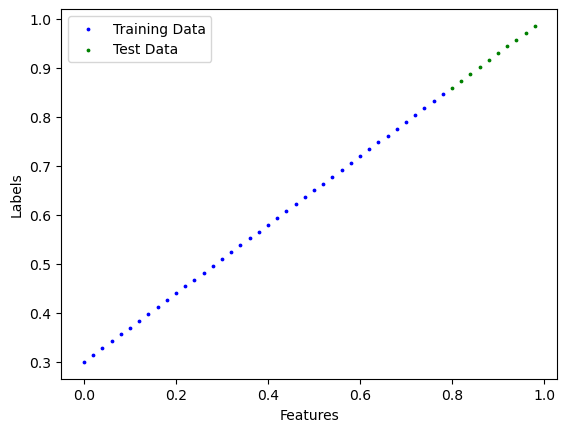

In [8]:
# As expected the function between the feature data and the output data is linear, based on the defined function
plot_data(train_X, test_X, train_y, test_y)

In [9]:
# Now to build the model. Will use Linear Regression
# PyTorch models are class based
class LinearRegressionModel(nn.Module): # Basically every neural network model inherits from nn.Module
    def __init__(self):
        super().__init__() # also calling init from parent class; req'd because we will be overloading methods from parent

        ### Initialize parameters for the model ####

        # Parameter is like a helper class that takes in a tensor and adds it to the model appropriately.
        # For more complicated models, the input tensor can have higher rank or instance variable will use other classes, like "nn.Conv1d"
        # Want grad to be true so that PyTorch can do autograd for backprop
        self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float32)) #initting with random val

        # Now to create another Parameter for the bias variable
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float32)) #initting with random val

        ### For a linear regression like this, can also use the nn.Linear() class ###
        # self.linear_layer = nn.Linear(in_features=1, out_features=1, bias=True)
        # in_features is dim of input features and out_features is dim of output.
        # In this model, the input dimension is 1 (only one weight) and it maps to 1 label (output dimension).
        # If using two weights (E.g. f(z) = Ax + By + C) input dim would be 2, output dim is still 1 for regression



    ### Define the forward pass logic ###

    # The forward pass function defines the computation that should be used
    # to predict the correct output labels from the input training data.
    # Of course, we'll use a first order linear function here:
    # NOTE: forward() is REQUIRED when defining a subclass of nn.Module (it overrides parent class instance method forward())
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        X is input tensor
        """
        return self.weights * X + self.bias
        # return self.linear_layer(X) if using the nn.Linear class



In [10]:
# Now lets inspect the model to see the parameters we've created and their values
seed = torch.manual_seed(6.28)
model = LinearRegressionModel()
print(tuple(model.parameters())) # method returns a generator

# Can also see a dict of the parameters with their associated values
model.state_dict()

(Parameter containing:
tensor([-1.8744], requires_grad=True), Parameter containing:
tensor([-0.9937], requires_grad=True))


OrderedDict([('weights', tensor([-1.8744])), ('bias', tensor([-0.9937]))])

tensor([[-2.4932],
        [-2.5307],
        [-2.5682],
        [-2.6056],
        [-2.6431],
        [-2.6806],
        [-2.7181],
        [-2.7556],
        [-2.7931],
        [-2.8306]])


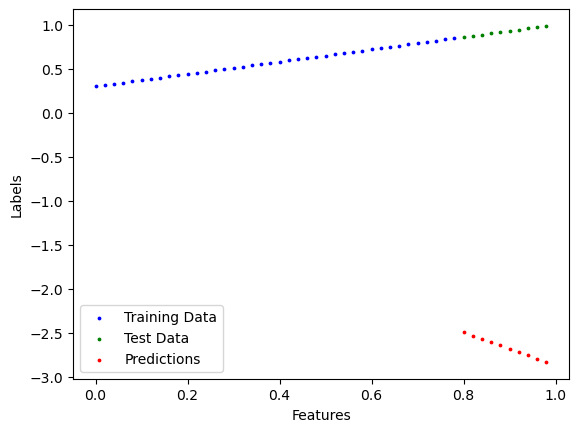

In [11]:
# To see how the model predicts values using the initialized parameters
# can use inference mode context manager. Context manager turns off autograd
# since inference is for predictions only.
with torch.inference_mode():
    y_preds = model(test_X)
print(y_preds)
plot_data(train_X, test_X, train_y, test_y, y_preds) # The prediction is obviously way off, it hasn't been trained!(just using random vals for weight and bias)

In [12]:
# Define loss and optimization functions
loss_fn = nn.L1Loss() # This is the mean squared error (can also use summed square error)
optimizer = SGD(params=model.parameters(), # stochastic graident descent
                lr=0.1) # lr is learning rate

In [13]:
# Lets create a training and testing loop to tune the parameters of our model
# and view how it's doing periodically.

# These lists will be used to store key values at different stages of training
# to show the model changing
epoch_count = []
train_loss_vals = []
test_loss_vals = []
epochs = 100

for epoch in range(epochs):
    ### Training Code ###
    model.train() # put model in training mode
    train_preds = model(train_X) # get models current predictions; NOTE: this will flag autograd without context manager
    train_loss = loss_fn(train_preds, train_y) # calculate a tensor with the loss values
    optimizer.zero_grad() # zero out the calculated gradients, it's accumulated by default
    train_loss.backward() # backprop to calculate gradients
    optimizer.step() # update weights based on calculated gradients

    ### Testing Code ###
    model.eval() # put model in evaluate mode
    with torch.inference_mode():
        test_preds = model(test_y) # get test preds after most recent param update
        test_loss = loss_fn(test_preds, test_y) # get the loss between test preds and test labels
    
    ### Diag Code ###
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        train_loss_vals.append(train_loss)
        test_loss_vals.append(test_loss)
        print(f'Epoch: {epoch} | MAE Training Loss: {train_loss} | MAE Test Loss: {test_loss}')



Epoch: 0 | MAE Training Loss: 2.2976789474487305 | MAE Test Loss: 3.5107359886169434
Epoch: 10 | MAE Training Loss: 1.1455785036087036 | MAE Test Loss: 2.150765895843506
Epoch: 20 | MAE Training Loss: 0.4025935232639313 | MAE Test Loss: 1.1206241846084595
Epoch: 30 | MAE Training Loss: 0.31263962388038635 | MAE Test Loss: 0.7899351119995117
Epoch: 40 | MAE Training Loss: 0.2768225073814392 | MAE Test Loss: 0.6669490337371826
Epoch: 50 | MAE Training Loss: 0.2423078566789627 | MAE Test Loss: 0.5785621404647827
Epoch: 60 | MAE Training Loss: 0.20802347362041473 | MAE Test Loss: 0.49017515778541565
Epoch: 70 | MAE Training Loss: 0.17365846037864685 | MAE Test Loss: 0.4017881751060486
Epoch: 80 | MAE Training Loss: 0.13928855955600739 | MAE Test Loss: 0.3203396201133728
Epoch: 90 | MAE Training Loss: 0.10500416904687881 | MAE Test Loss: 0.2319527566432953


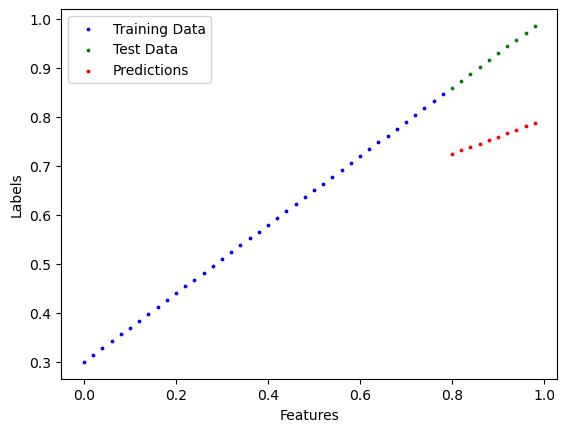

In [14]:
# Now lets see how the model predictions match the true values after initial training
with torch.inference_mode():
    y_preds = model(test_X)
plot_data(train_X, test_X, train_y, test_y, y_preds) # The prediction is much better than before, but still off slightly

In [15]:
# Now lets bundle the loop into a function so that the hyperparameters can be tuned faster
def train_model(model: LinearRegressionModel,
                feature_train: torch.Tensor = train_X,
                feature_test: torch.Tensor = test_X,
                label_train: torch.Tensor = train_y,
                label_test: torch.Tensor = test_y,
                epochs: int = 100,
                lr: float = 0.1) -> dict:

    # Define loss and optimization functions
    loss_fn = nn.L1Loss()
    optimizer = SGD(params=model.parameters(),
                    lr=lr) # lr is learning rate

    # Define lists for useful values
    epoch_count = []
    train_loss_vals = []
    test_loss_vals = []

    # Train/Test loop
    for epoch in range(epochs):
        ### Training Code ###
        model.train() # put model in training mode
        train_preds = model(feature_train) # get models current predictions; NOTE: this will flag autograd without context manager
        train_loss = loss_fn(train_preds, label_train) # calculate a tensor with the loss values
        optimizer.zero_grad() # zero out the calculated gradients, it's accumulated by default
        train_loss.backward() # backprop to calculate gradients
        optimizer.step() # update weights based on calculated gradients

        ### Testing Code ###
        model.eval() # put model in evaluate mode
        with torch.inference_mode():
            test_preds = model(label_test) # get test preds after most recent param update
            test_loss = loss_fn(test_preds, label_test) # get the loss between test preds and test labels

        ### Diag Code ###
        if epoch % 10 == 0: # record progress every 10 epochs
            epoch_count.append(epoch)
            train_loss_vals.append(train_loss.item())
            test_loss_vals.append(test_loss.item())
            print(f'Epoch: {epoch} | MAE Training Loss: {train_loss} | MAE Test Loss: {test_loss}')
    
    # Return useful values as dict
    return {
        'epochs': epoch_count,
        'train_loss': train_loss_vals,
        'test_loss': test_loss_vals
    }

In [16]:
# Can also define a function that plots the training and test losses as a function of epoch
def plot_loss(train_loss_vals: list, test_loss_vals: list, epoch_vals: list) -> None:
    """
    Creates plot depicting the loss curves as function of epoch
    """
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    # plot the test loss vs epoch
    plt.plot(epoch_vals, test_loss_vals, c='b', label='Test Loss')
    # plot the train loss vs epoch
    plt.plot(epoch_vals, train_loss_vals, c='g', label='Training Loss')
    plt.legend()
    plt.show()

OrderedDict([('weights', tensor([-1.8744])), ('bias', tensor([-0.9937]))])
Epoch: 0 | MAE Training Loss: 2.2976789474487305 | MAE Test Loss: 3.5107359886169434
Epoch: 10 | MAE Training Loss: 1.1455785036087036 | MAE Test Loss: 2.150765895843506
Epoch: 20 | MAE Training Loss: 0.4025935232639313 | MAE Test Loss: 1.1206241846084595
Epoch: 30 | MAE Training Loss: 0.31263962388038635 | MAE Test Loss: 0.7899351119995117
Epoch: 40 | MAE Training Loss: 0.2768225073814392 | MAE Test Loss: 0.6669490337371826
Epoch: 50 | MAE Training Loss: 0.2423078566789627 | MAE Test Loss: 0.5785621404647827
Epoch: 60 | MAE Training Loss: 0.20802347362041473 | MAE Test Loss: 0.49017515778541565
Epoch: 70 | MAE Training Loss: 0.17365846037864685 | MAE Test Loss: 0.4017881751060486
Epoch: 80 | MAE Training Loss: 0.13928855955600739 | MAE Test Loss: 0.3203396201133728
Epoch: 90 | MAE Training Loss: 0.10500416904687881 | MAE Test Loss: 0.2319527566432953
Epoch: 100 | MAE Training Loss: 0.07062245905399323 | MAE Tes

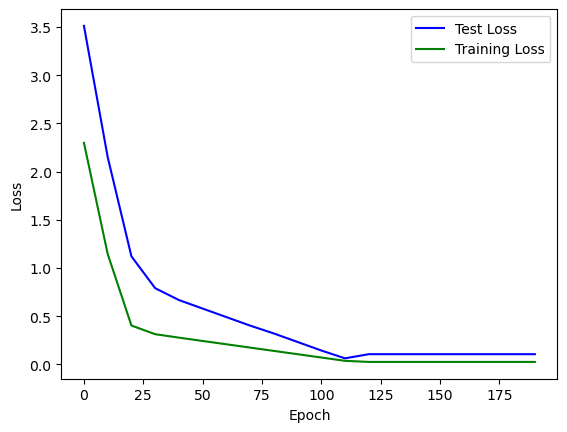

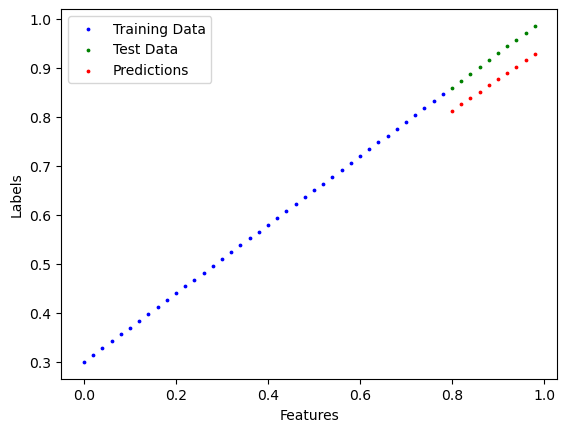

In [17]:
# Changing the epoch count (while also reinitializing the model to get original weights)
seed = torch.manual_seed(6.28)
model = LinearRegressionModel()
print(model.state_dict())

vals = train_model(
    model,
    epochs=200,
    lr=0.1
)

with torch.inference_mode():
    y_preds = model(test_X)
plot_loss(vals['train_loss'], vals['test_loss'], vals['epochs'])
plot_data(train_X, test_X, train_y, test_y, y_preds) # The prediction is much better than the naive one, but still off slightly

OrderedDict([('weights', tensor([-1.8744])), ('bias', tensor([-0.9937]))])
Epoch: 0 | MAE Training Loss: 2.2976789474487305 | MAE Test Loss: 3.6331334114074707
Epoch: 10 | MAE Training Loss: 2.1824684143066406 | MAE Test Loss: 3.497135877609253
Epoch: 20 | MAE Training Loss: 2.067258358001709 | MAE Test Loss: 3.3611385822296143
Epoch: 30 | MAE Training Loss: 1.9520485401153564 | MAE Test Loss: 3.2251410484313965
Epoch: 40 | MAE Training Loss: 1.8368383646011353 | MAE Test Loss: 3.089143991470337
Epoch: 50 | MAE Training Loss: 1.721628189086914 | MAE Test Loss: 2.9531466960906982
Epoch: 60 | MAE Training Loss: 1.6064180135726929 | MAE Test Loss: 2.8171491622924805
Epoch: 70 | MAE Training Loss: 1.4912079572677612 | MAE Test Loss: 2.681151866912842
Epoch: 80 | MAE Training Loss: 1.3759976625442505 | MAE Test Loss: 2.545154571533203
Epoch: 90 | MAE Training Loss: 1.2607876062393188 | MAE Test Loss: 2.4091567993164062
Epoch: 100 | MAE Training Loss: 1.1455774307250977 | MAE Test Loss: 2.27

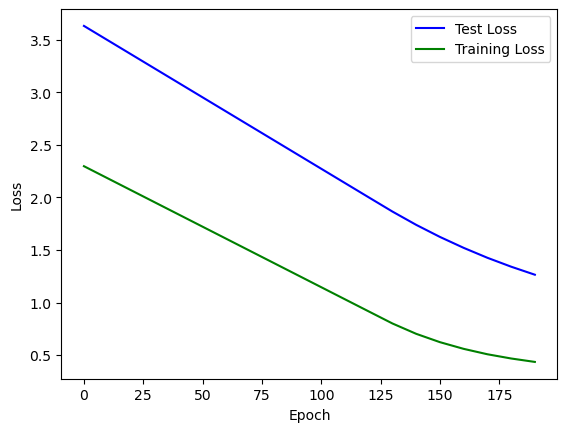

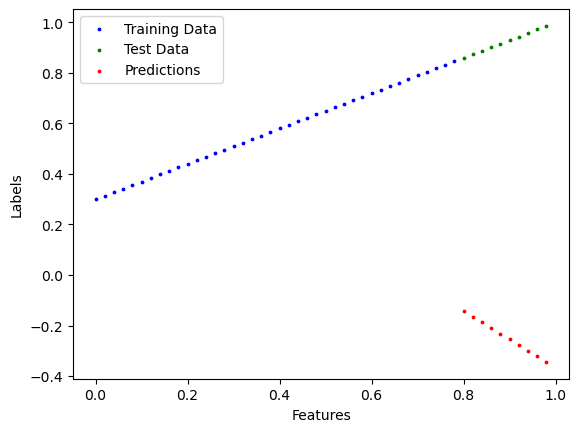

In [18]:
# Changing the epoch count and lr (while also reinitializing the model to get original weights)
seed = torch.manual_seed(6.28)
model = LinearRegressionModel()
print(model.state_dict())

vals = train_model(
    model,
    epochs=200,
    lr=0.01
)

with torch.inference_mode():
    y_preds = model(test_X)
plot_loss(vals['train_loss'], vals['test_loss'], vals['epochs'])
plot_data(train_X, test_X, train_y, test_y, y_preds) # Changing the learning rate slowed down learning a lot, lets up the epoch count

OrderedDict([('weights', tensor([-1.8744])), ('bias', tensor([-0.9937]))])
Epoch: 0 | MAE Training Loss: 2.2976789474487305 | MAE Test Loss: 3.592334270477295
Epoch: 10 | MAE Training Loss: 1.836838722229004 | MAE Test Loss: 3.0483462810516357
Epoch: 20 | MAE Training Loss: 1.3759987354278564 | MAE Test Loss: 2.5043587684631348
Epoch: 30 | MAE Training Loss: 0.9151588678359985 | MAE Test Loss: 1.9603710174560547
Epoch: 40 | MAE Training Loss: 0.5550426840782166 | MAE Test Loss: 1.484820008277893
Epoch: 50 | MAE Training Loss: 0.40723705291748047 | MAE Test Loss: 1.1722148656845093
Epoch: 60 | MAE Training Loss: 0.3485220670700073 | MAE Test Loss: 0.9749126434326172
Epoch: 70 | MAE Training Loss: 0.32189708948135376 | MAE Test Loss: 0.8528155088424683
Epoch: 80 | MAE Training Loss: 0.3047439157962799 | MAE Test Loss: 0.773572564125061
Epoch: 90 | MAE Training Loss: 0.290294349193573 | MAE Test Loss: 0.7216394543647766
Epoch: 100 | MAE Training Loss: 0.27633434534072876 | MAE Test Loss: 

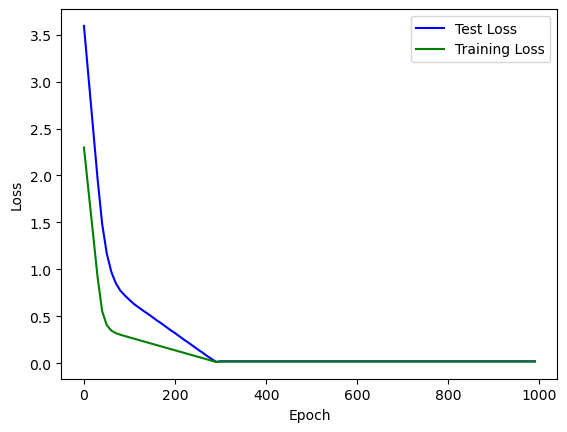

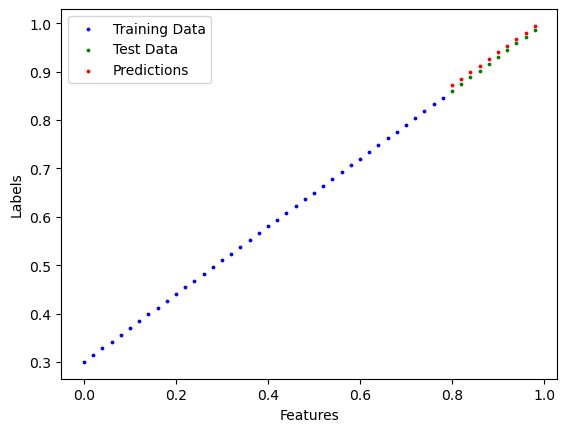

In [19]:
# Increasing the epoch count (while also reinitializing the model to get original weights)
seed = torch.manual_seed(6.28)
model = LinearRegressionModel()
print(model.state_dict())

vals = train_model(
    model,
    epochs=1000,
    lr=0.04
)

with torch.inference_mode():
    y_preds = model(test_X)
plot_loss(vals['train_loss'], vals['test_loss'], vals['epochs'])
plot_data(train_X, test_X, train_y, test_y, y_preds) # The prediction is much better than before

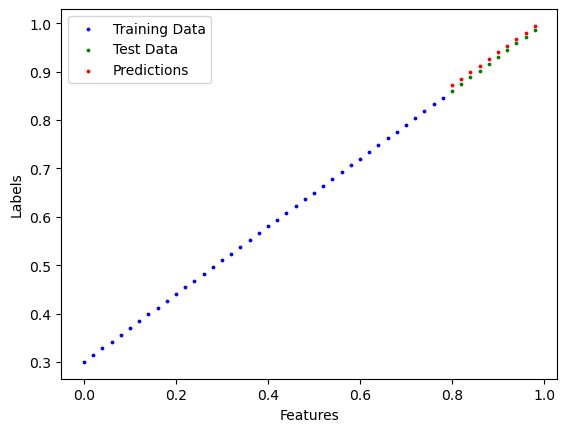

In [20]:
# Now lets try moving everything to the GPU and doing inference there (NOTE: Seems like training on the M1 isn't supported yet (autograd not supp))
model.to('mps')
test_X = test_X.to('mps')


with torch.inference_mode():
    y_preds = model(test_X) # inference successfully done on the GPU!
plot_data(train_X, test_X.to(device='cpu'), train_y, test_y, y_preds.to(device='cpu')) # Have to move the tensors back to CPU before using NumPy (called by plt)

## Saving a trained model

Saving a trained model to use for inference later is important for portability. The most common way is by saving the trained model's `state_dict`, which contains the optimized model parameters for a given training set. Pytorch doesn't have a defined data structure for this, it uses Pickle to just serialize the `state_dict`.

In [21]:
# Define model directory
MODEL_DIR = '../../data/models/'
MODEL_FNAME = 'lin_reg_model_0.pth'

# Define function to save the model
def save_model(model_dir: str, filename: str,  model: nn.Module) -> None:
    print(f'Saving model state_dict to {model_dir + filename}')
    torch.save(obj=model.state_dict(), f=model_dir + filename)

save_model(MODEL_DIR, MODEL_FNAME, model)

Saving model state_dict to ../../data/models/lin_reg_model_0.pth


In [22]:
# Now that the trained model parameters are saved, can create a new model instance
# and load the saved parameters.

loaded_model = LinearRegressionModel()
loaded_model.load_state_dict(torch.load(MODEL_DIR + MODEL_FNAME)) # self_documenting code here!
print(tuple(loaded_model.parameters())) 
print(tuple(model.parameters())) # Note how the two parameters are identical!

(Parameter containing:
tensor([0.6836], requires_grad=True), Parameter containing:
tensor([0.3243], requires_grad=True))
(Parameter containing:
tensor([0.6836], device='mps:0', requires_grad=True), Parameter containing:
tensor([0.3243], device='mps:0', requires_grad=True))


/opt/homebrew/Caskroom/miniconda/base/envs/iq_ml_cnn/lib/python3.10/site-packages/torch/_tensor_str.py:103: UserWarning: The operator 'aten::bitwise_and.Tensor_out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at  /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1659484612588/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(tensor_view, torch.isfinite(tensor_view) & tensor_view.ne(0))
